<a href="https://colab.research.google.com/github/SUdvisha/FoodRecommender/blob/main/Copy_of_DE_FoodRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -------------------- 📦 Install Dependencies --------------------
!pip install -q textblob spacy matplotlib seaborn wordcloud
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all th

In [ ]:
# -------------------- 📚 Imports --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import spacy
import ast
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import re

tqdm.pandas()
sns.set(style='whitegrid')
nlp = spacy.load("en_core_web_sm")

In [ ]:
# -------------------- 📥 Load Dataset --------------------
recipes = pd.read_csv("recipes.csv")

In [ ]:
# Parse ingredient parts
def parse_ingredients(raw):
    if pd.isna(raw):
        return ''
    try:
        # Match contents inside c("...") and split them
        matches = re.findall(r'c\((.*?)\)', raw)
        if matches:
            items_str = matches[0]
            items = re.findall(r'"(.*?)"', items_str)
            return ' '.join(items)
        return ''
    except:
        return ''

recipes['ParsedIngredients'] = recipes['RecipeIngredientParts'].apply(parse_ingredients)

# Combine and preprocess text
recipes['Description'] = recipes['Description'].fillna('')
recipes['CombinedText'] = recipes['Description'] + ' ' + recipes['ParsedIngredients']

In [ ]:
# NLP preprocessing
def preprocess_text(text):
    blob = TextBlob(text.lower())
    return ' '.join([word.lemmatize() for word in blob.words if word.isalpha()])

recipes['ProcessedText'] = recipes['CombinedText'].progress_apply(preprocess_text)

  0%|          | 0/522517 [00:00<?, ?it/s]

In [ ]:
# Parse ISO 8601 duration (e.g., PT30M, PT1H30M)
def parse_duration(duration):
    try:
        h = re.findall(r'(\d+)H', duration)
        m = re.findall(r'(\d+)M', duration)
        return int(h[0])*60 + int(m[0]) if h and m else int(h[0])*60 if h else int(m[0]) if m else 0
    except:
        return 0

recipes['CookTimeMins'] = recipes['CookTime'].fillna('PT0M').apply(parse_duration)
recipes['PrepTimeMins'] = recipes['PrepTime'].fillna('PT0M').apply(parse_duration)
recipes['TotalTimeMins'] = recipes['TotalTime'].fillna('PT0M').apply(parse_duration)

In [ ]:
# Ingredient count
recipes['NumIngredients'] = recipes['ParsedIngredients'].apply(lambda x: len(x.split()))

In [ ]:
# Fill missing numeric values
num_cols = ['AggregatedRating', 'ReviewCount', 'RecipeServings']
for col in num_cols:
    recipes[col] = recipes[col].fillna(recipes[col].median())

In [ ]:
# Replace missing mood-relevant keywords
recipes['RecipeCategory'] = recipes['RecipeCategory'].fillna('Unknown')

In [ ]:
# -------------------- 🧠 FEATURE ENGINEERING --------------------

# Nutritional Ratios
recipes['CaloriesPerServing'] = recipes['Calories'] / recipes['RecipeServings']
recipes['ProteinToFatRatio'] = recipes['ProteinContent'] / (recipes['FatContent'] + 1e-6)
recipes['CarbToFatRatio'] = recipes['CarbohydrateContent'] / (recipes['FatContent'] + 1e-6)

In [ ]:
# Complexity level
def complexity(mins, ingredients):
    if mins < 60 and ingredients <= 10:
        return 'Easy'
    elif mins < 120:
        return 'Medium'
    else:
        return 'Hard'

recipes['RecipeComplexity'] = recipes.apply(lambda row: complexity(row['TotalTimeMins'], row['NumIngredients']), axis=1)

In [ ]:
def tag_mood(text):
    text = text.lower()

    # Energizing: Spicy, high-energy foods
    if 'spicy' in text or 'chili' in text or 'pepper' in text or 'curry' in text or 'jalapeno' in text:
        return 'energizing'

    # Comfort: Indulgent, rich foods
    elif 'chocolate' in text or 'cheese' in text or 'butter' in text or 'cake' in text or 'pizza' in text or 'ice cream' in text:
        return 'comfort'

    # Light: Fresh, healthy, and refreshing foods
    elif 'salad' in text or 'fruit' in text or 'smoothie' in text or 'vegan' in text or 'grilled' in text or 'low-fat' in text:
        return 'light'

    # Indulgent: Heavier, satisfying foods
    elif 'burger' in text or 'fried' in text or 'pasta' in text or 'steak' in text or 'pie' in text:
        return 'indulgent'

    # Refreshing: Cool, hydrating foods
    elif 'watermelon' in text or 'cucumber' in text or 'lemon' in text or 'mint' in text or 'sorbet' in text:
        return 'refreshing'

    # Hearty: Filling, warm, and comforting meals
    elif 'soup' in text or 'stew' in text or 'chili' in text or 'roast' in text or 'casserole' in text:
        return 'hearty'

    # Sweet: Desserts and sugary treats
    elif 'cake' in text or 'cookies' in text or 'brownie' in text or 'pie' in text or 'pudding' in text:
        return 'sweet'

    # Detox: Cleansing and light foods
    elif 'detox' in text or 'cleanse' in text or 'green' in text or 'kombucha' in text or 'matcha' in text:
        return 'detox'

    # Neutral: Default for no significant mood tagging
    else:
        return 'neutral'

# Apply the mood tagging function
recipes['MoodTag'] = recipes['ProcessedText'].apply(tag_mood)

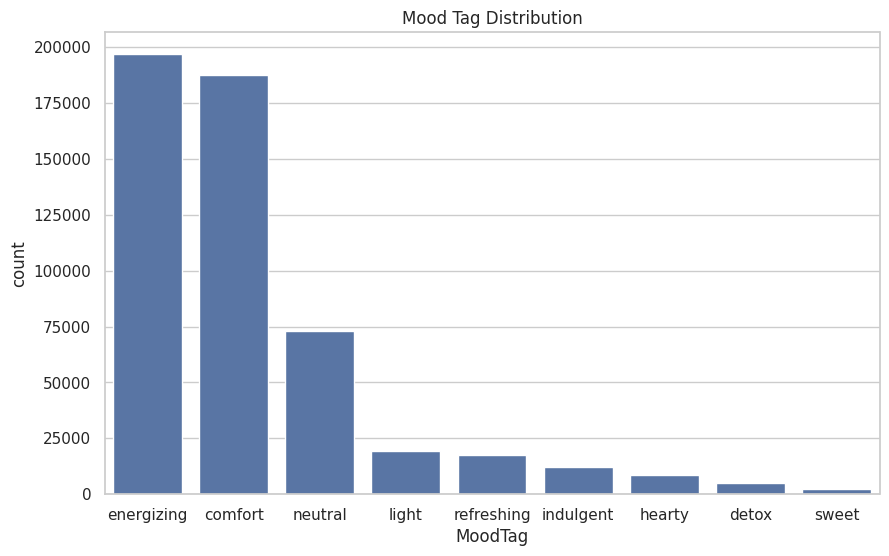

In [ ]:
# Mood tag distribution
plt.figure(figsize=(10,6))
sns.countplot(data=recipes, x='MoodTag', order=recipes['MoodTag'].value_counts().index)
plt.title("Mood Tag Distribution")
plt.show()

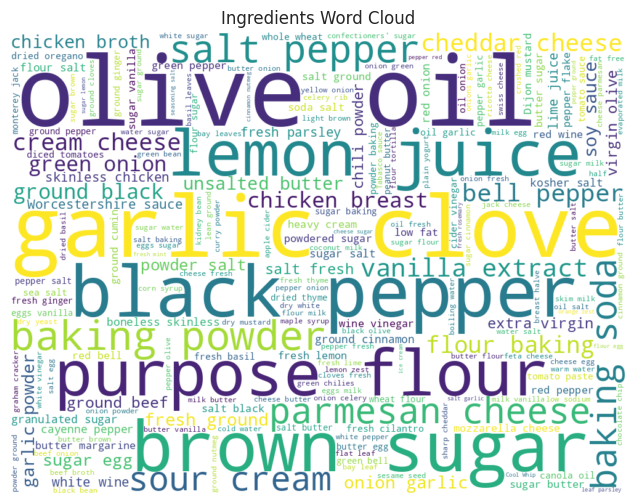

In [ ]:
# Ingredients word cloud
wordcloud = WordCloud(width=1000, height=750, background_color='white').generate(' '.join(recipes['ParsedIngredients']))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ingredients Word Cloud")
plt.show()

In [ ]:
def detect_mood(user_input):
    user_input = user_input.lower()
    polarity = TextBlob(user_input).sentiment.polarity

    # Keyword-based override (better match to mood categories)
    if any(word in user_input for word in ['spicy', 'pepper', 'curry', 'hot']):
        return 'energizing'
    elif any(word in user_input for word in ['tired', 'cheesy', 'butter', 'chocolate', 'cake']):
        return 'comfort'
    elif any(word in user_input for word in ['salad', 'vegan', 'healthy', 'smoothie']):
        return 'light'
    elif any(word in user_input for word in ['burger', 'pasta', 'fried', 'heavy']):
        return 'indulgent'
    elif any(word in user_input for word in ['cool', 'fresh', 'lemon', 'mint', 'refreshing']):
        return 'refreshing'
    elif any(word in user_input for word in ['soup', 'stew', 'roast']):
        return 'hearty'
    elif any(word in user_input for word in ['sweet', 'dessert', 'cookies', 'pie']):
        return 'sweet'
    elif any(word in user_input for word in ['detox', 'cleanse', 'green juice', 'matcha']):
        return 'detox'

    # Fallback: sentiment-based detection
    if polarity < -0.3:
        return 'comfort'
    elif polarity > 0.3:
        return 'energizing'
    else:
        return 'light'

In [ ]:
def recommend_recipes(user_input, top_n=5):
    mood = detect_mood(user_input)
    print(f"\n🧠 Detected Mood: {mood}")

    mood_recipes = recipes[recipes['MoodTag'] == mood]
    if mood_recipes.empty:
        print("⚠️ No recipes matched the detected mood. Showing random selection.")
        mood_recipes = recipes.sample(500)

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = tfidf.fit_transform(mood_recipes['ProcessedText'])

    processed_input = preprocess_text(user_input)
    user_vec = tfidf.transform([processed_input])

    # Similarity
    sim_scores = cosine_similarity(user_vec, tfidf_matrix).flatten()
    top_indices = sim_scores.argsort()[::-1][:top_n]

    return mood_recipes.iloc[top_indices][[
        'Name', 'Description', 'ParsedIngredients', 'MoodTag',
        'CaloriesPerServing', 'RecipeComplexity'
    ]].reset_index(drop=True)

# -------------------- 🧪 TRY IT OUT --------------------

user_input = "I'm really exhausted and want something cheesy and comforting"
recommendations = recommend_recipes(user_input, top_n=5)

print("\n🍽️ Recommended Recipes:\n")
print(recommendations)


🧠 Detected Mood: comfort

🍽️ Recommended Recipes:

                                  Name  \
0           How Cheesy Do You Want 'em   
1      Molly's Cheesy Potato Casserole   
2                   Comforting Cookies   
3                      Omelet Scramble   
4  Chocolate Peanut Butter Cup Oatmeal   

                                         Description  \
0  Make and share this How Cheesy Do You Want 'em...   
1  IT'S REALLY CHEESY, CREAMY, AND AWESOME.... IT...   
2  Make and share this Comforting Cookies recipe ...   
3  This is really just scrambled eggs with a whol...   
4  A really yummy and comforting breakfast that i...   

                                   ParsedIngredients  MoodTag  \
0                              butter cheddar cheese  comfort   
1  hash browns butter onion sour cream Velveeta c...  comfort   
2  eggs vanilla brown sugar sugar all-purpose flo...  comfort   
3           eggs milk cheese mushroom cheese parsley  comfort   
4  nonfat milk quick oats creamy 

In [ ]:
test_inputs = [
    "I'm feeling low and want something sweet and indulgent.",
    "Just finished a workout, need something energizing and spicy.",
    "Looking for a light and refreshing meal with fruits or salad.",
    "I’m tired, give me comfort food with butter and cheese.",
    "Feeling healthy today, maybe something vegan or detoxing.",
    "Craving something hearty like soup or stew.",
    "Dessert time! I want cookies or a slice of pie.",
    "Need a cool drink or something lemony and minty."
]

for user_input in test_inputs:
    print("=" * 80)
    print(f"User Input: {user_input}")
    recommendations = recommend_recipes(user_input, top_n=5)
    print("\n🍽️ Top 3 Recommended Recipes:\n")
    print(recommendations[['Name', 'MoodTag', 'CaloriesPerServing', 'RecipeComplexity']])
    print("\n")


User Input: I'm feeling low and want something sweet and indulgent.

🧠 Detected Mood: sweet

🍽️ Top 3 Recommended Recipes:

                             Name MoodTag  CaloriesPerServing RecipeComplexity
0                     Brownie Mix   sweet          112.350000             Easy
1  Crock Pot Basmati Rice Pudding   sweet           21.387500             Hard
2                Low Fat Brownies   sweet            4.250000             Easy
3            Sweet Barley Pudding   sweet            6.966667           Medium
4      Low Fat Low Sugar Brownies   sweet           32.283333           Medium


User Input: Just finished a workout, need something energizing and spicy.

🧠 Detected Mood: energizing

🍽️ Top 3 Recommended Recipes:

                                                Name     MoodTag  \
0                                      Spicey Cashew  energizing   
1                           Swedish Cinnamon Cookies  energizing   
2  Kittencal's Pan-Seared Steak, Stove Top-To-Ove...  energiz